## Data Understanding

Integrantes:
- Melissa Pérez
- Renatto Guzmán
- Sebastían Silva
- Javier Alvarado

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_DIR = Path("../data")
OUTPUT_DIR = Path("./clean")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Limpieza de datos

In [2]:
# Cargar CSV

categoria = pd.read_csv(DATA_DIR / "Categoria.csv")
cliente   = pd.read_csv(DATA_DIR / "Cliente.csv", encoding="latin-1")
events    = pd.read_csv(DATA_DIR / "events.csv")
marca     = pd.read_csv(DATA_DIR / "marca.csv")
producto  = pd.read_csv(DATA_DIR / "producto.csv")

# Vista rápida
for name, df in [("categoria", categoria), ("cliente", cliente), ("events", events), ("marca", marca), ("producto", producto)]:
    print(f"\n== {name} ==")
    display(df.head())



== categoria ==


,id,categoria
0,1,SCOTCH WHISKIES
1,2,STRAIGHT BOURBON WHISKIES
2,3,BLENDED WHISKIES
3,4,IMPORTED DRY GINS
4,5,DECANTERS & SPECIALTY PACKAGES



== cliente ==


,id,nombre,apellido,nacimiento,genero,empresa,idioma,nit,puesto,ciudad,correo,telefono
0,599528.0,Samuel,Ward,4/6/89,Male,Yakijo,Marathi,411-44-7088,Geologist IV,Wangjing,sward0@tamu.edu,86-(786)608-5061
1,121688.0,Willie,Gonzales,6/29/72,Male,Zoonoodle,Maltese,701-87-7540,Programmer III,El Corozo,wgonzales1@apache.org,58-(265)301-3397
2,552148.0,Betty,Spencer,9/2/83,Female,Youtags,Dhivehi,373-88-4503,Engineer III,Jinhua,bspencer2@shutterfly.com,86-(195)193-9042
3,102019.0,Beverly,Jordan,1/15/72,Female,Fivespan,Hindi,447-80-5871,Software Test Engineer IV,Salvacion,bjordan3@vimeo.com,63-(652)708-7688
4,189384.0,Cynthia,Flores,2/6/71,Female,Jabbersphere,Tsonga,803-60-8259,Speech Pathologist,Khorol,cflores4@webeden.co.uk,380-(373)389-5435



== events ==


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN



== marca ==


,id,marca
0,1,Diageo Americas
1,2,Heaven Hill Brands
2,3,"Sazerac Co., Inc."
3,4,Sage Beverages
4,5,MHW Ltd



== producto ==


,id,categoria_id,nombre,marca_id,volumen,precio
0,356475,9.0,Crown Royal Honey,1.0,750,22.49
1,15335,9.0,Crown Royal Regal Apple Mini,1.0,300,11.03
2,81345,9.0,Crown Royal Regal Apple,1.0,200,7.08
3,150318,9.0,Crown Royal Xr Canadian Whiskey,1.0,750,98.99
4,310791,9.0,Crown Royal Canadian Whisky Mini,1.0,300,11.03


In [3]:
def print_section(title):
    print(f"\n{'='*20} {title} {'='*20}")


def duplicates_report(df: pd.DataFrame, key_cols):
    dup_mask = df.duplicated(subset=key_cols, keep=False)
    return df.loc[dup_mask].sort_values(key_cols)

def integrity_report():
    reports = []

    # producto.categoria_id vs categoria.id
    cat_valid = set(categoria['id'])
    prod_cats = set(producto['categoria_id'])
    missing_cats = sorted(list(prod_cats - cat_valid))
    reports.append(("producto.categoria_id -> categoria.id", missing_cats))

    # producto.marca_id vs marca.id
    marca_valid = set(marca['id'])
    prod_marcas = set(producto['marca_id'])
    missing_marcas = sorted(list(prod_marcas - marca_valid))
    reports.append(("producto.marca_id -> marca.id", missing_marcas))

    # events.itemid vs producto.id (puede haber views de items no catalogados)
    prod_ids = set(producto['id'])
    event_items = set(events['itemid'].dropna().astype(int))
    missing_items = sorted(list(event_items - prod_ids))
    reports.append(("events.itemid -> producto.id", missing_items))

    rep_df = pd.DataFrame(reports, columns=["relación", "claves_huerfanas"])
    return rep_df

In [4]:
# %% [markdown]
# ## Casting de tipos

# Cliente: nacimiento a datetime (formato tipo M/D/YY). Forzamos y reportamos fallos.
cliente['_nacimiento_raw'] = cliente['nacimiento']
cliente['nacimiento'] = pd.to_datetime(cliente['nacimiento'], errors='coerce', infer_datetime_format=True)

# Events: timestamp ms -> datetime
events['_timestamp_raw'] = events['timestamp']
events['timestamp'] = pd.to_numeric(events['timestamp'], errors='coerce')
events['event_time'] = pd.to_datetime(events['timestamp'], unit='ms', errors='coerce')

# Normalización de tipos clave
for c in ['id']:
    if c in categoria.columns:
        categoria[c] = pd.to_numeric(categoria[c], errors='coerce').astype('Int64')
    if c in marca.columns:
        marca[c] = pd.to_numeric(marca[c], errors='coerce').astype('Int64')

for c in ['id', 'categoria_id', 'marca_id', 'volumen']:
    if c in producto.columns:
        producto[c] = pd.to_numeric(producto[c], errors='coerce')

for c in ['visitorid', 'itemid', 'transactionid']:
    if c in events.columns:
        events[c] = pd.to_numeric(events[c], errors='coerce')

print_section("Fechas inválidas en cliente.nacimiento")
display(cliente[cliente['nacimiento'].isna()][['id','_nacimiento_raw']])

print_section("Timestamps inválidos en events")
display(events[events['event_time'].isna()][['_timestamp_raw','timestamp']].head(10))



==================== Fechas inválidas en cliente.nacimiento ====================


/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_17200/2815049422.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  cliente['nacimiento'] = pd.to_datetime(cliente['nacimiento'], errors='coerce', infer_datetime_format=True)
/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_17200/2815049422.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cliente['nacimiento'] = pd.to_datetime(cliente['nacimiento'], errors='coerce', infer_datetime_format=True)


,id,_nacimiento_raw
11719,NaN,NaN
11720,NaN,NaN
11721,NaN,NaN
11722,NaN,NaN
11723,NaN,NaN
...,...,...
11995,NaN,NaN
11996,NaN,NaN
11997,NaN,NaN
11998,NaN,NaN



==================== Timestamps inválidos en events ====================


,_timestamp_raw,timestamp


In [5]:
# Auditoría de calidad general

# Nulos por tabla
for name, df in [("categoria", categoria), ("cliente", cliente), ("events", events), ("marca", marca), ("producto", producto)]:
    print_section(f"Nulos por columna — {name}")
    display(df.isna().sum().to_frame("n_nulos"))

# Duplica}dos
print_section("Duplicados por clave primaria esperada")
dup_cats   = duplicates_report(categoria, ['id'])
dup_marca  = duplicates_report(marca, ['id'])
dup_prod   = duplicates_report(producto, ['id'])
dup_client = duplicates_report(cliente, ['id'])
dup_events = duplicates_report(events, ['timestamp','visitorid','event','itemid'])

for title, d in [("categoria.id", dup_cats), ("marca.id", dup_marca), ("producto.id", dup_prod),
                 ("cliente.id", dup_client), ("events (ts, visitorid, event, itemid)", dup_events)]:
    print(f"\n-- {title} --")
    display(d if not d.empty else pd.DataFrame({"mensaje":["Sin duplicados detectados."]}))

# Cardinalidades rápidas
print_section("Cardinalidades")
card = {
    "categoria": len(categoria),
    "marca": len(marca),
    "producto": len(producto),
    "cliente": len(cliente),
    "events": len(events),
}
pd.Series(card, name="n_filas")



==================== Nulos por columna — categoria ====================


,n_nulos
id,0
categoria,0



==================== Nulos por columna — cliente ====================


,n_nulos
id,281
nombre,281
apellido,281
nacimiento,281
genero,281
empresa,281
idioma,281
nit,281
puesto,281
ciudad,281



==================== Nulos por columna — events ====================


,n_nulos
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644
_timestamp_raw,0
event_time,0



==================== Nulos por columna — marca ====================


,n_nulos
id,0
marca,0



==================== Nulos por columna — producto ====================


,n_nulos
id,0
categoria_id,1028
nombre,0
marca_id,876
volumen,0
precio,6



==================== Duplicados por clave primaria esperada ====================

-- categoria.id --


,mensaje
0,Sin duplicados detectados.



-- marca.id --


,mensaje
0,Sin duplicados detectados.



-- producto.id --


,id,categoria_id,nombre,marca_id,volumen,precio
0,356475,9.0,Crown Royal Honey,1.0,750,22.49
6248,356475,74.0,Dekuyper Sour Peach Pucker,23.0,200,2.27



-- cliente.id --


,id,nombre,apellido,nacimiento,genero,empresa,idioma,nit,puesto,ciudad,correo,telefono,_nacimiento_raw
11719,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11720,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11721,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11722,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11723,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



-- events (ts, visitorid, event, itemid) --


,timestamp,visitorid,event,itemid,transactionid,_timestamp_raw,event_time
1466550,1430639017006,771203,view,250578,NaN,1430639017006,2015-05-03 07:43:37.006
1471736,1430639017006,771203,view,250578,NaN,1430639017006,2015-05-03 07:43:37.006
1482986,1430780975099,234788,addtocart,33,NaN,1430780975099,2015-05-04 23:09:35.099
1496938,1430780975099,234788,addtocart,33,NaN,1430780975099,2015-05-04 23:09:35.099
1489030,1430788228572,594432,addtocart,311596,NaN,1430788228572,2015-05-05 01:10:28.572
...,...,...,...,...,...,...,...
1448726,1442435309784,739520,addtocart,308273,NaN,1442435309784,2015-09-16 20:28:29.784
1460622,1442502594303,159701,addtocart,139030,NaN,1442502594303,2015-09-17 15:09:54.303
1462130,1442502594303,159701,addtocart,139030,NaN,1442502594303,2015-09-17 15:09:54.303
1457308,1442525777257,143657,addtocart,37115,NaN,1442525777257,2015-09-17 21:36:17.257



==================== Cardinalidades ====================


categoria        101
marca            307
producto       12026
cliente        12000
events       2756101
Name: n_filas, dtype: int64

In [6]:
# Integridad

fk_report = integrity_report()
fk_report


,relación,claves_huerfanas
0,producto.categoria_id -> categoria.id,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,producto.marca_id -> marca.id,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,events.itemid -> producto.id,"[3, 4, 6, 9, 16, 17, 22, 24, 26, 29, 32, 33, 3..."


In [7]:
# Validaciones de contenido

# Email (patrón simple)
email_pat = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$")
cliente['correo_valido'] = cliente['correo'].astype(str).str.match(email_pat)

# Teléfono (contar dígitos tras limpiar)
cliente['_telefono_raw'] = cliente['telefono']
cliente['telefono_digitos'] = cliente['telefono'].astype(str).str.replace(r"\D", "", regex=True)
cliente['telefono_valido_len'] = cliente['telefono_digitos'].str.len().between(8, 15)  # rango laxo

# Género: conjunto permitido
generos_permitidos = {"Male","Female","M","F"}
cliente['genero_valido'] = cliente['genero'].astype(str).str.strip().isin(generos_permitidos)

print_section("Correos inválidos")
display(cliente[~cliente['correo_valido']][['id','correo']])

print_section("Teléfonos con longitud sospechosa")
display(cliente[~cliente['telefono_valido_len']][['id','_telefono_raw','telefono_digitos']])

print_section("Género no estandarizado")
display(cliente[~cliente['genero_valido']][['id','genero']])



==================== Correos inválidos ====================


,id,correo
11719,NaN,NaN
11720,NaN,NaN
11721,NaN,NaN
11722,NaN,NaN
11723,NaN,NaN
...,...,...
11995,NaN,NaN
11996,NaN,NaN
11997,NaN,NaN
11998,NaN,NaN



==================== Teléfonos con longitud sospechosa ====================


,id,_telefono_raw,telefono_digitos
11719,NaN,NaN,
11720,NaN,NaN,
11721,NaN,NaN,
11722,NaN,NaN,
11723,NaN,NaN,
...,...,...,...
11995,NaN,NaN,
11996,NaN,NaN,
11997,NaN,NaN,
11998,NaN,NaN,



==================== Género no estandarizado ====================


,id,genero
11719,NaN,NaN
11720,NaN,NaN
11721,NaN,NaN
11722,NaN,NaN
11723,NaN,NaN
...,...,...
11995,NaN,NaN
11996,NaN,NaN
11997,NaN,NaN
11998,NaN,NaN


In [8]:
# Chequeos específicos

# producto.precio y volumen
print_section("Precios/volúmenes no positivos o nulos en producto")
display(producto[(producto['precio'] <= 0) | (producto['precio'].isna()) | (producto['volumen'] <= 0) | (producto['volumen'].isna())])

# events: tipos de evento y tasas de transacción
print_section("Eventos disponibles")
display(events['event'].value_counts(dropna=False).to_frame("conteo"))

print_section("Porcentaje de eventos con transactionid")
pct_tx = events['transactionid'].notna().mean()
print(f"{pct_tx:.2%} de eventos tienen transactionid (esperado: bajo si la mayoría son 'view').")

# items en events que no existen en catálogo
print_section("Items en events que NO existen en producto")
missing_items_df = pd.DataFrame(sorted(list(set(events['itemid'].dropna().astype(int)) - set(producto['id']))), columns=['itemid_faltante'])
display(missing_items_df.head(50) if not missing_items_df.empty else pd.DataFrame({"mensaje":["Todos los itemid de events están en producto (con la muestra actual)"]}))

# producto.categoria_id inexistente
print_section("Categorias inexistentes referenciadas por producto")
missing_cats_df = pd.DataFrame(sorted(list(set(producto['categoria_id']) - set(categoria['id']))), columns=['categoria_id_faltante'])
display(missing_cats_df.head(50) if not missing_cats_df.empty else pd.DataFrame({"mensaje":["Todas las categorías referenciadas existen"]}))



==================== Precios/volúmenes no positivos o nulos en producto ====================


,id,categoria_id,nombre,marca_id,volumen,precio
1146,218626,28.0,Dr. Mcgillicuddy's Cherry Schnapps,3.0,375,NaN
4178,281544,36.0,E & J Cask & Cream (dno),18.0,375,NaN
6144,17189,11.0,Glen Keith Sing Malt Scotch(dno),7.0,750,NaN
6442,151538,8.0,Barton Light Rum,19.0,1750,NaN
7864,51354,19.0,Boru Crazzberry Vodka,40.0,750,NaN
8094,116587,19.0,Turi Vodka Estonian Dno,47.0,750,0.00
8104,207115,19.0,Mezzaluna Vodka,47.0,750,0.00
8798,357802,11.0,Littlemill 12yr,63.0,750,0.00
9940,51360,19.0,Hammer Sickle Vodka,112.0,750,0.00
10090,310556,24.0,Voo Doo Spice Rum,139.0,750,0.00



==================== Eventos disponibles ====================


,conteo
event,
view,2664312
addtocart,69332
transaction,22457



==================== Porcentaje de eventos con transactionid ====================
0.81% de eventos tienen transactionid (esperado: bajo si la mayoría son 'view').

==================== Items en events que NO existen en producto ====================


,itemid_faltante
0,3
1,4
2,6
3,9
4,16
5,17
6,22
7,24
8,26
9,29



==================== Categorias inexistentes referenciadas por producto ====================


,categoria_id_faltante
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [9]:
# Transformaciones mínimas (no destructivas, nuevas columnas)

# Cliente: normalizar strings (trim) y estandarizar genero a 'Male'/'Female' si aplica
cliente['nombre']   = cliente['nombre'].astype(str).str.strip()
cliente['apellido'] = cliente['apellido'].astype(str).str.strip()
cliente['ciudad']   = cliente['ciudad'].astype(str).str.strip()
cliente['correo']   = cliente['correo'].astype(str).str.strip().str.lower()

cliente['genero_std'] = np.where(cliente['genero'].astype(str).str.upper().str[:1].eq('M'), 'Male',
                          np.where(cliente['genero'].astype(str).str.upper().str[:1].eq('F'), 'Female', cliente['genero']))

# Teléfono: dejar sólo dígitos y formatear E.164 si trae código (heurístico)
def to_e164(digits: str):
    if not isinstance(digits, str): return np.nan
    if digits.startswith("00"):  # 00xx... -> +xx...
        digits = "+" + digits[2:]
    if digits.startswith("+" ):
        return digits
    # si tiene 11-15 dígitos asumimos que incluye país (ej. 58..., 86..., etc.)
    if 11 <= len(digits) <= 15:
        return "+" + digits
    # si tiene 8-10, dejar como local sin '+'
    return digits

cliente['telefono_e164'] = cliente['telefono_digitos'].apply(to_e164)

# Events: columnas auxiliares de fecha
if 'event_time' in events:
    events['date'] = events['event_time'].dt.date
    events['hour'] = events['event_time'].dt.hour

display(cliente.head())
display(events.head())


,id,nombre,apellido,nacimiento,genero,empresa,idioma,nit,puesto,ciudad,correo,telefono,_nacimiento_raw,correo_valido,_telefono_raw,telefono_digitos,telefono_valido_len,genero_valido,genero_std,telefono_e164
0,599528.0,Samuel,Ward,1989-04-06,Male,Yakijo,Marathi,411-44-7088,Geologist IV,Wangjing,sward0@tamu.edu,86-(786)608-5061,4/6/89,True,86-(786)608-5061,867866085061,True,True,Male,+867866085061
1,121688.0,Willie,Gonzales,2072-06-29,Male,Zoonoodle,Maltese,701-87-7540,Programmer III,El Corozo,wgonzales1@apache.org,58-(265)301-3397,6/29/72,True,58-(265)301-3397,582653013397,True,True,Male,+582653013397
2,552148.0,Betty,Spencer,1983-09-02,Female,Youtags,Dhivehi,373-88-4503,Engineer III,Jinhua,bspencer2@shutterfly.com,86-(195)193-9042,9/2/83,True,86-(195)193-9042,861951939042,True,True,Female,+861951939042
3,102019.0,Beverly,Jordan,2072-01-15,Female,Fivespan,Hindi,447-80-5871,Software Test Engineer IV,Salvacion,bjordan3@vimeo.com,63-(652)708-7688,1/15/72,True,63-(652)708-7688,636527087688,True,True,Female,+636527087688
4,189384.0,Cynthia,Flores,2071-02-06,Female,Jabbersphere,Tsonga,803-60-8259,Speech Pathologist,Khorol,cflores4@webeden.co.uk,380-(373)389-5435,2/6/71,True,380-(373)389-5435,3803733895435,True,True,Female,+3803733895435


,timestamp,visitorid,event,itemid,transactionid,_timestamp_raw,event_time,date,hour
0,1433221332117,257597,view,355908,NaN,1433221332117,2015-06-02 05:02:12.117,2015-06-02,5
1,1433224214164,992329,view,248676,NaN,1433224214164,2015-06-02 05:50:14.164,2015-06-02,5
2,1433221999827,111016,view,318965,NaN,1433221999827,2015-06-02 05:13:19.827,2015-06-02,5
3,1433221955914,483717,view,253185,NaN,1433221955914,2015-06-02 05:12:35.914,2015-06-02,5
4,1433221337106,951259,view,367447,NaN,1433221337106,2015-06-02 05:02:17.106,2015-06-02,5


In [10]:
# Exportar datasets limpios (sin sobrescribir los originales)

categoria.to_csv(OUTPUT_DIR / "categoria_clean.csv", index=False)
marca.to_csv(OUTPUT_DIR   / "marca_clean.csv", index=False)
producto.to_csv(OUTPUT_DIR/ "producto_clean.csv", index=False)

cliente_clean = cliente.drop(columns=[c for c in ['_nacimiento_raw','_telefono_raw'] if c in cliente.columns])
cliente_clean.to_csv(OUTPUT_DIR / "cliente_clean.csv", index=False)

events_clean = events.drop(columns=[c for c in ['_timestamp_raw'] if c in events.columns])
events_clean.to_csv(OUTPUT_DIR / "events_clean.csv", index=False)

list(OUTPUT_DIR.glob("*.csv"))


[PosixPath('clean/events_clean.csv'),
 PosixPath('clean/marca_clean.csv'),
 PosixPath('clean/producto_clean.csv'),
 PosixPath('clean/cliente_clean.csv'),
 PosixPath('clean/categoria_clean.csv')]

In [11]:
# Resumen ejecutivo (tablas con hallazgos clave)

resumen = {
    "categoria": {
        "filas": len(categoria),
        "nulos_totales": int(categoria.isna().sum().sum()),
        "duplicados_id": int(duplicates_report(categoria, ['id']).shape[0]),
    },
    "marca": {
        "filas": len(marca),
        "nulos_totales": int(marca.isna().sum().sum()),
        "duplicados_id": int(duplicates_report(marca, ['id']).shape[0]),
    },
    "producto": {
        "filas": len(producto),
        "nulos_totales": int(producto.isna().sum().sum()),
        "duplicados_id": int(duplicates_report(producto, ['id']).shape[0]),
        "fk_cat_faltantes": int(len(set(producto['categoria_id']) - set(categoria['id']))),
        "fk_marca_faltantes": int(len(set(producto['marca_id']) - set(marca['id']))),
    },
    "cliente": {
        "filas": len(cliente),
        "nulos_totales": int(cliente.isna().sum().sum()),
        "duplicados_id": int(duplicates_report(cliente, ['id']).shape[0]),
        "correos_invalidos": int((~cliente['correo_valido']).sum()),
        "telefonos_sospechosos": int((~cliente['telefono_valido_len']).sum()),
        "genero_no_std": int((~cliente['genero_valido']).sum()),
        "nacimiento_nulo": int(cliente['nacimiento'].isna().sum()),
    },
    "events": {
        "filas": len(events),
        "nulos_totales": int(events.isna().sum().sum()),
        "items_fuera_catalogo": int(len(set(events['itemid'].dropna().astype(int)) - set(producto['id']))),
        "pct_con_txid": round(events['transactionid'].notna().mean()*100, 2),
    }
}

summary_df = pd.DataFrame(resumen).T
summary_df


,filas,nulos_totales,duplicados_id,fk_cat_faltantes,fk_marca_faltantes,correos_invalidos,telefonos_sospechosos,genero_no_std,nacimiento_nulo,items_fuera_catalogo,pct_con_txid
categoria,101.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marca,307.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producto,12026.0,1910.0,2.0,1028.0,876.0,NaN,NaN,NaN,NaN,NaN,NaN
cliente,12000.0,3091.0,281.0,NaN,NaN,281.0,281.0,281.0,281.0,NaN,NaN
events,2756101.0,2733644.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223036.0,0.81


# Análisis exploratorio

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

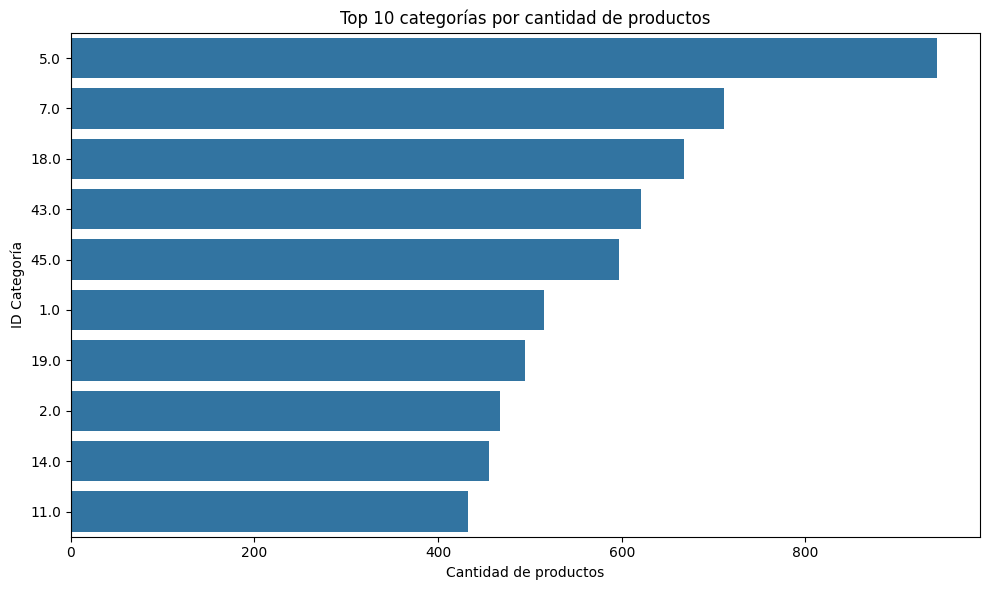

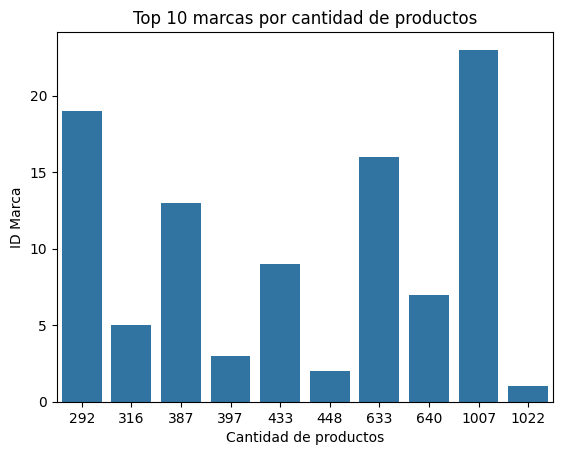

In [13]:
# perfil general del catálogo de productos
productos_por_categoria = producto.groupby('categoria_id')['id'].count().sort_values(ascending=False).head(10)
productos_por_marca = producto.groupby('marca_id')['id'].count().sort_values(ascending=False).head(10)

# Gráfica: productos por categoría
plt.figure(figsize=(10, 6))
sns.barplot(x=productos_por_categoria.values, y=productos_por_categoria.index.astype(str))
plt.title("Top 10 categorías por cantidad de productos")
plt.xlabel("Cantidad de productos")
plt.ylabel("ID Categoría")
plt.tight_layout()
plt.show()

# Gráfica: productos por marca (top 10)
sns.barplot(x=productos_por_marca.values, y=productos_por_marca.index)
plt.title("Top 10 marcas por cantidad de productos")
plt.xlabel("Cantidad de productos")
plt.ylabel("ID Marca")
plt.show()

Estadísticas de edad:
Edad mínima: 25.0
Edad máxima: 50.0
Edad promedio: 33.1
Valores nulos: 3232


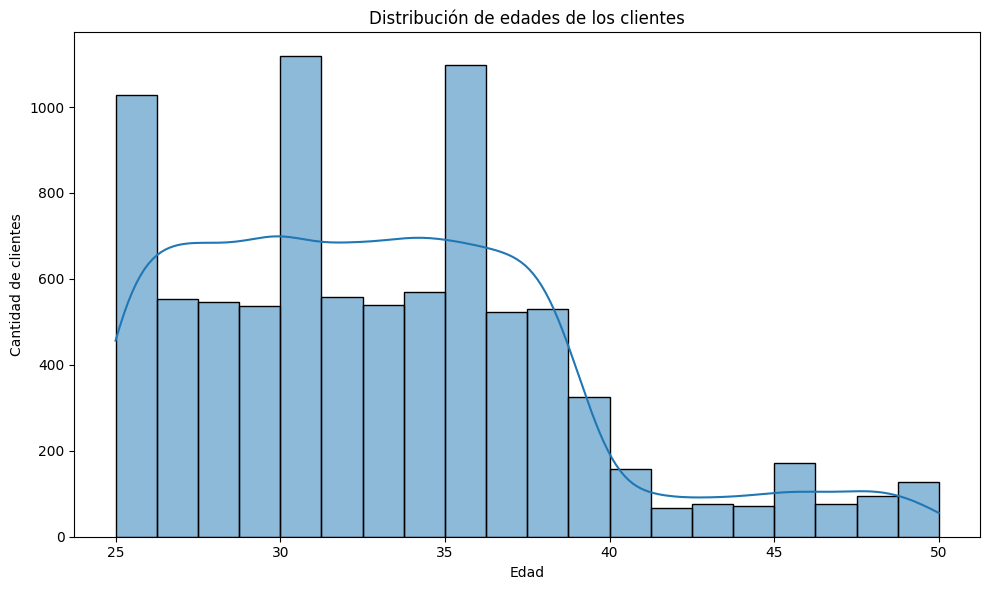

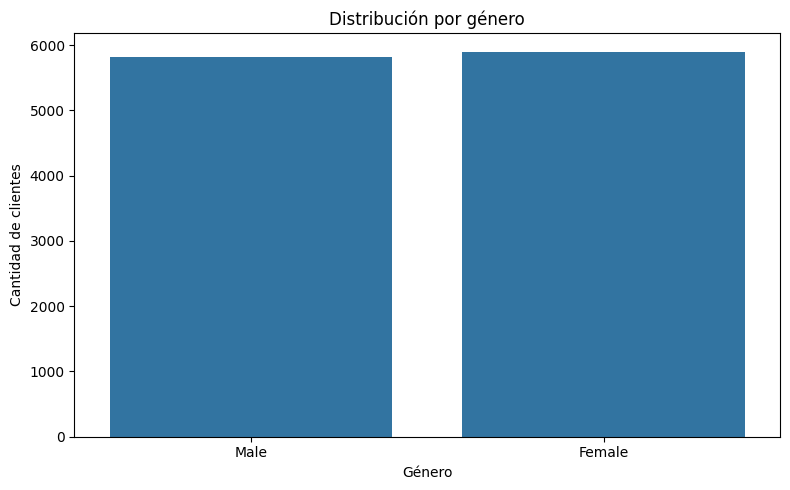

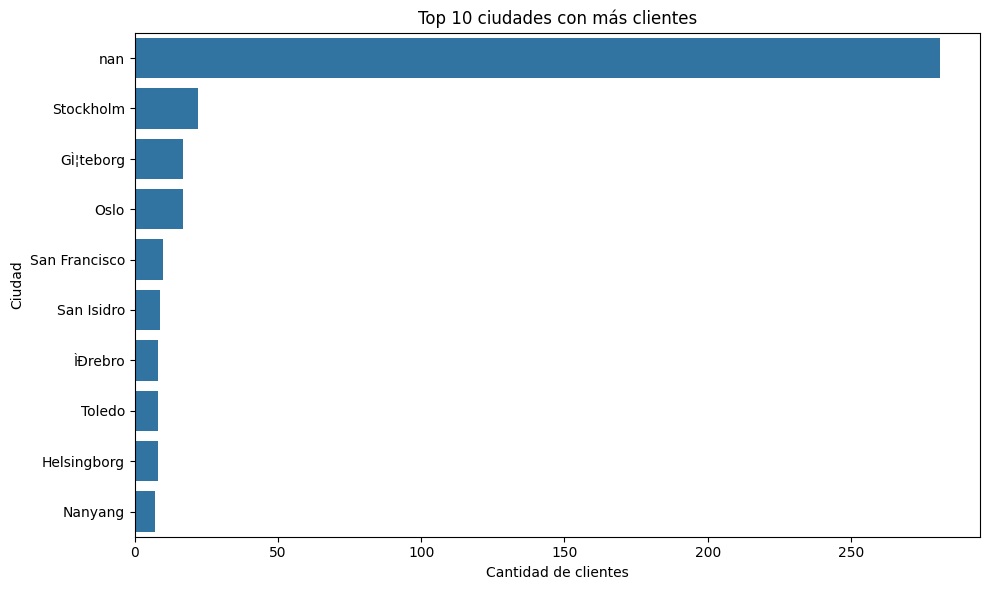

In [14]:
# perfil de clientes
def calcular_edad(fecha_nacimiento):
    if pd.isna(fecha_nacimiento):
        return np.nan
    
    hoy = date.today()
    edad = hoy.year - fecha_nacimiento.year
    
    # Ajustar si aún no ha pasado el cumpleaños este año
    if (hoy.month, hoy.day) < (fecha_nacimiento.month, fecha_nacimiento.day):
        edad -= 1
    
    # Filtrar edades inválidas (negativas o muy altas)
    if edad < 0 or edad > 120:
        return np.nan
    
    return edad

cliente['edad'] = cliente['nacimiento'].apply(calcular_edad)

# Mostrar estadísticas de edad antes de graficar
print("Estadísticas de edad:")
print(f"Edad mínima: {cliente['edad'].min()}")
print(f"Edad máxima: {cliente['edad'].max()}")
print(f"Edad promedio: {cliente['edad'].mean():.1f}")
print(f"Valores nulos: {cliente['edad'].isna().sum()}")

# Distribución de edades
plt.figure(figsize=(10, 6))
sns.histplot(cliente['edad'].dropna(), bins=20, kde=True)
plt.title("Distribución de edades de los clientes")
plt.xlabel("Edad")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()

# Distribución por género
plt.figure(figsize=(8, 5))
sns.countplot(x='genero_std', data=cliente)
plt.title("Distribución por género")
plt.xlabel("Género")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()

# Top 10 ciudades con más clientes
clientes_por_ciudad = cliente['ciudad'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=clientes_por_ciudad.values, y=clientes_por_ciudad.index)
plt.title("Top 10 ciudades con más clientes")
plt.xlabel("Cantidad de clientes")
plt.ylabel("Ciudad")
plt.tight_layout()
plt.show()

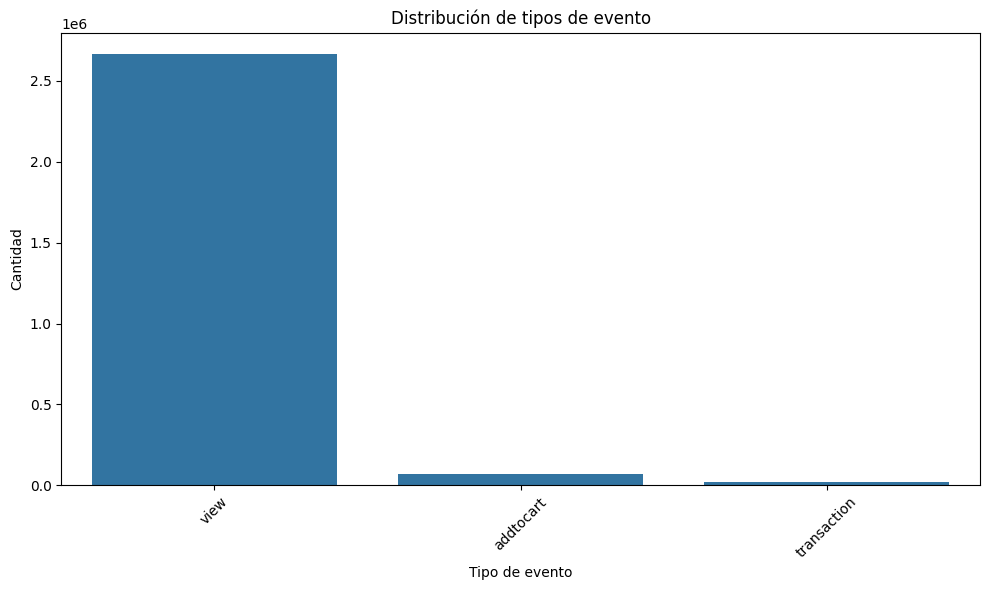

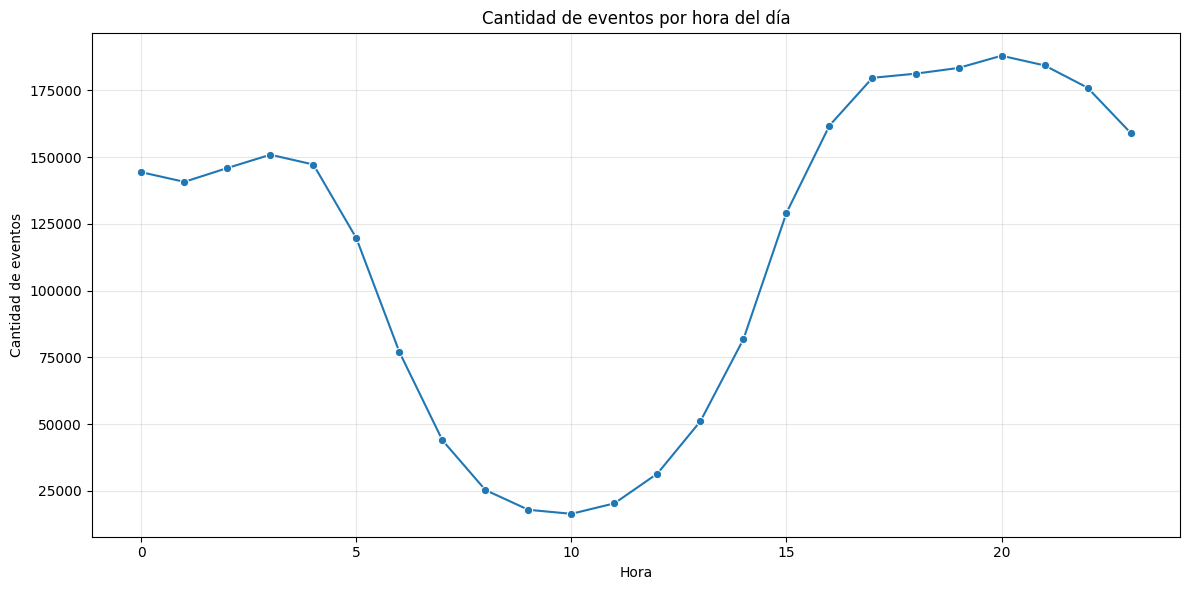

Tasa de conversión: 0.81%


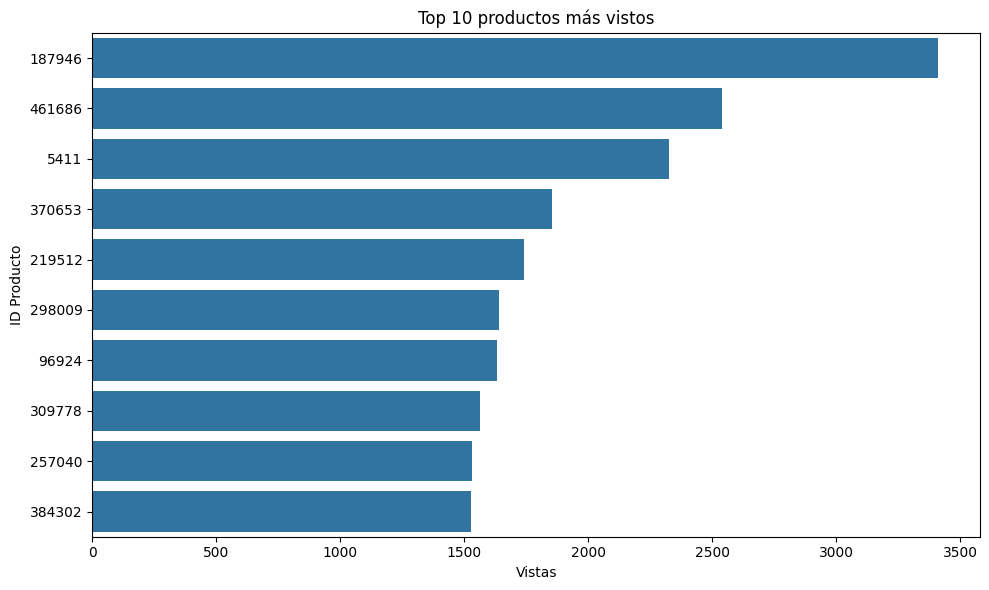

In [15]:
# comportamiento de eventos
plt.figure(figsize=(10, 6))
sns.countplot(x='event', data=events, order=events['event'].value_counts().index)
plt.title("Distribución de tipos de evento")
plt.xlabel("Tipo de evento")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Eventos por hora
eventos_por_hora = events.groupby('hour')['event'].count()
plt.figure(figsize=(12, 6))
sns.lineplot(x=eventos_por_hora.index, y=eventos_por_hora.values, marker='o')
plt.title("Cantidad de eventos por hora del día")
plt.xlabel("Hora")
plt.ylabel("Cantidad de eventos")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tasa de conversión
conversion_rate = events['transactionid'].notna().mean() * 100
print(f"Tasa de conversión: {conversion_rate:.2f}%")

# Top productos más vistos
top_vistos = events[events['event'] == 'view']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_vistos.values, y=top_vistos.index.astype(str))
plt.title("Top 10 productos más vistos")
plt.xlabel("Vistas")
plt.ylabel("ID Producto")
plt.tight_layout()
plt.show()

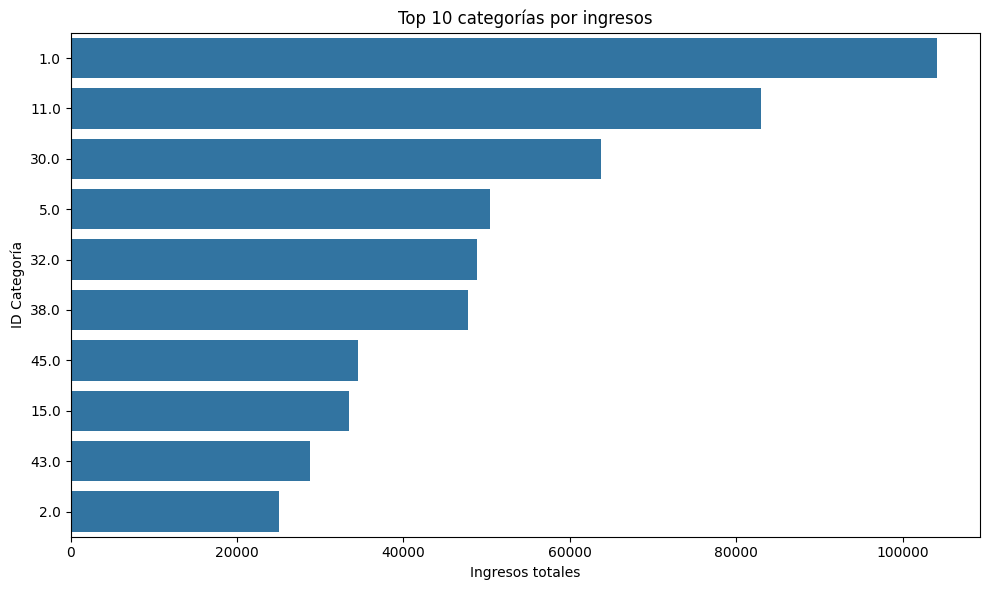

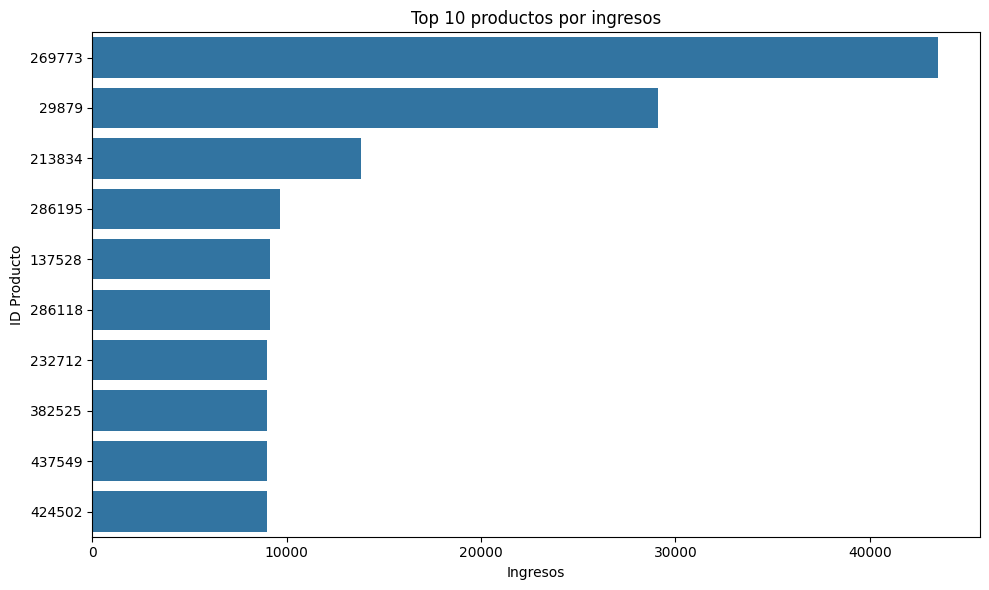

In [16]:
# relacion productos-ventas
events_ventas = events.merge(producto[['id','precio','categoria_id']], left_on='itemid', right_on='id', how='left')

# Filtrar solo ventas
ventas = events_ventas[events_ventas['transactionid'].notna()]

# Ingresos por categoría
ingresos_categoria = ventas.groupby('categoria_id')['precio'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=ingresos_categoria.values, y=ingresos_categoria.index.astype(str))
plt.title("Top 10 categorías por ingresos")
plt.xlabel("Ingresos totales")
plt.ylabel("ID Categoría")
plt.tight_layout()
plt.show()

# Top productos por ingresos
top_ingresos = ventas.groupby('itemid')['precio'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ingresos.values, y=top_ingresos.index.astype(str))
plt.title("Top 10 productos por ingresos")
plt.xlabel("Ingresos")
plt.ylabel("ID Producto")
plt.tight_layout()
plt.show()

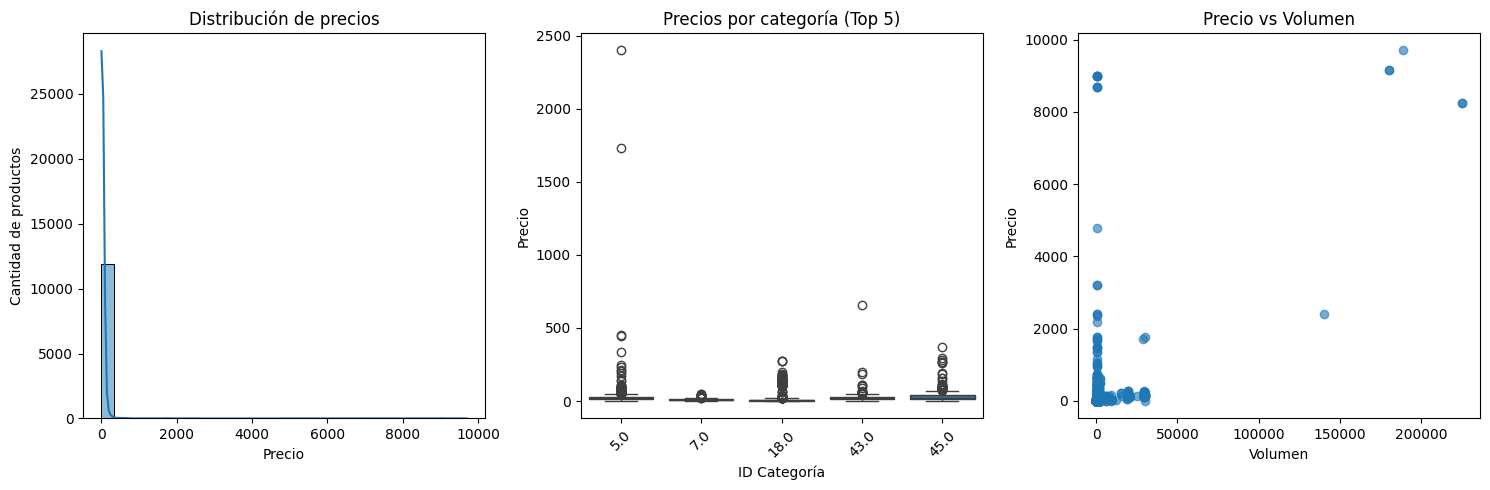

Estadísticas de precios:
count    12020.000000
mean        38.770502
std        309.980074
min          0.000000
25%          8.250000
50%         14.250000
75%         25.500000
max       9702.000000
Name: precio, dtype: float64


In [17]:
# Análisis de precios del catálogo
plt.figure(figsize=(15, 5))

# Distribución de precios
plt.subplot(1, 3, 1)
sns.histplot(producto['precio'].dropna(), bins=30, kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio")
plt.ylabel("Cantidad de productos")

# Boxplot de precios por categoría (top 5)
plt.subplot(1, 3, 2)
top_cats = productos_por_categoria.head(5).index
productos_top_cats = producto[producto['categoria_id'].isin(top_cats)]
sns.boxplot(x='categoria_id', y='precio', data=productos_top_cats)
plt.title("Precios por categoría (Top 5)")
plt.xlabel("ID Categoría")
plt.ylabel("Precio")
plt.xticks(rotation=45)

# Relación precio vs volumen
plt.subplot(1, 3, 3)
plt.scatter(producto['volumen'], producto['precio'], alpha=0.6)
plt.title("Precio vs Volumen")
plt.xlabel("Volumen")
plt.ylabel("Precio")

plt.tight_layout()
plt.show()

# Estadísticas descriptivas de precios
print("Estadísticas de precios:")
print(producto['precio'].describe())

/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_17200/1473146995.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conversion_por_hora = events.groupby('hour').apply(lambda x: x['transactionid'].notna().mean() * 100)


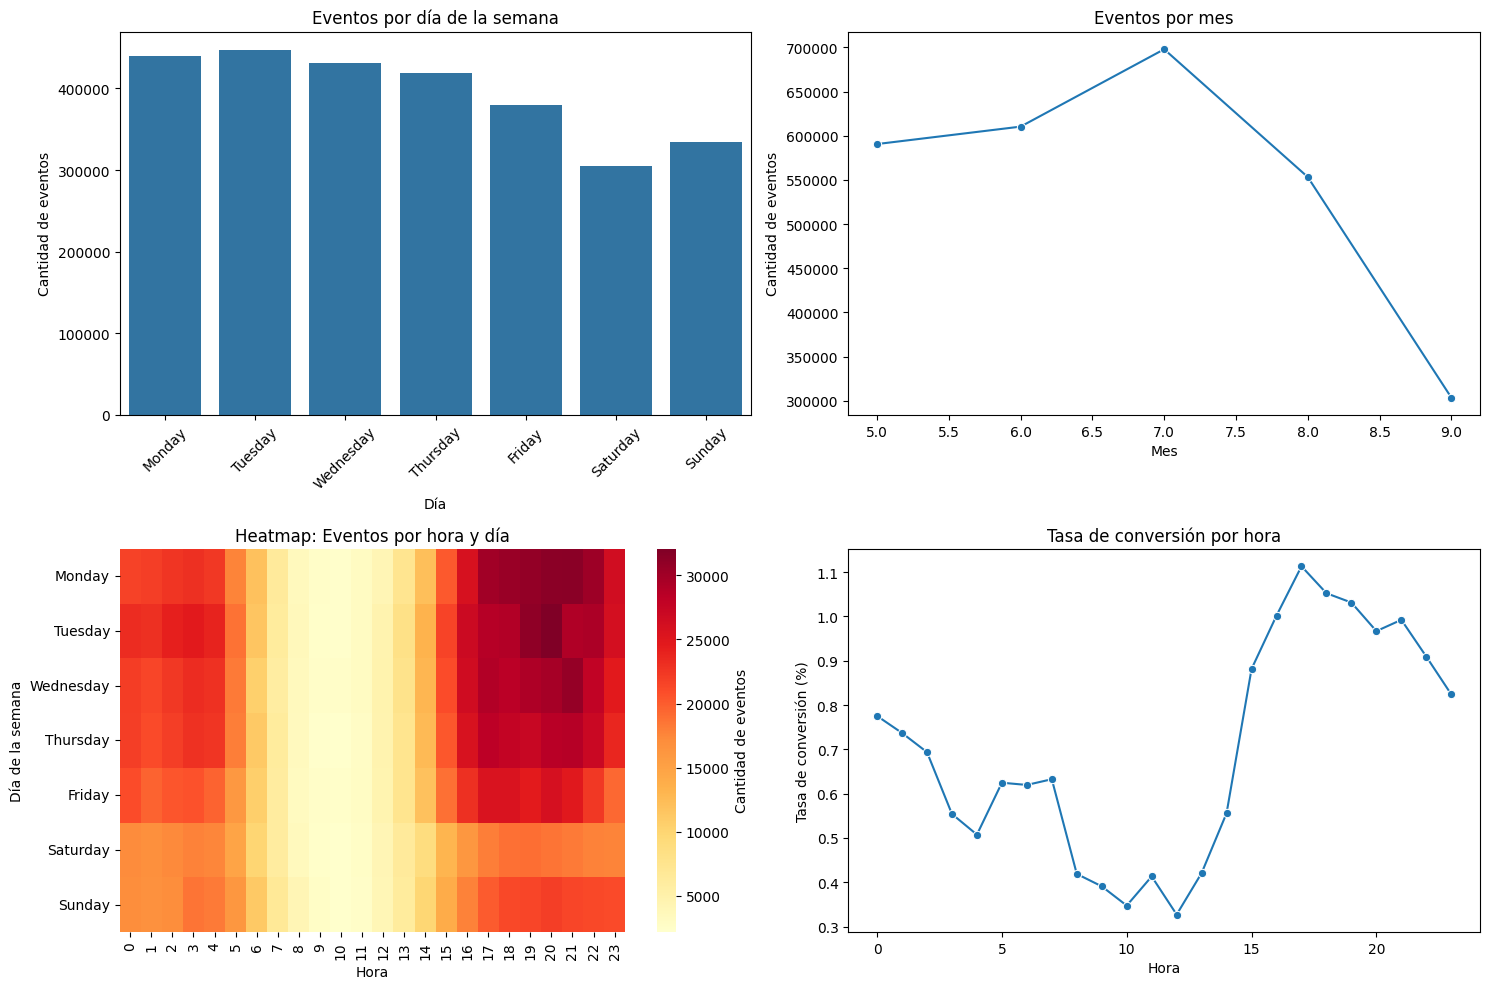

In [18]:
# Análisis temporal avanzado
plt.figure(figsize=(15, 10))

# Eventos por día de la semana
events['dia_semana'] = events['event_time'].dt.day_name()
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.subplot(2, 2, 1)
eventos_por_dia = events['dia_semana'].value_counts().reindex(orden_dias)
sns.barplot(x=eventos_por_dia.index, y=eventos_por_dia.values)
plt.title("Eventos por día de la semana")
plt.xlabel("Día")
plt.ylabel("Cantidad de eventos")
plt.xticks(rotation=45)

# Eventos por mes
plt.subplot(2, 2, 2)
events['mes'] = events['event_time'].dt.month
eventos_por_mes = events['mes'].value_counts().sort_index()
sns.lineplot(x=eventos_por_mes.index, y=eventos_por_mes.values, marker='o')
plt.title("Eventos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de eventos")

# Heatmap de eventos por hora y día de la semana
plt.subplot(2, 2, 3)
heatmap_data = events.groupby(['dia_semana', 'hour']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(orden_dias)
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Cantidad de eventos'})
plt.title("Heatmap: Eventos por hora y día")
plt.xlabel("Hora")
plt.ylabel("Día de la semana")

# Tasa de conversión por hora
plt.subplot(2, 2, 4)
conversion_por_hora = events.groupby('hour').apply(lambda x: x['transactionid'].notna().mean() * 100)
sns.lineplot(x=conversion_por_hora.index, y=conversion_por_hora.values, marker='o')
plt.title("Tasa de conversión por hora")
plt.xlabel("Hora")
plt.ylabel("Tasa de conversión (%)")

plt.tight_layout()
plt.show()

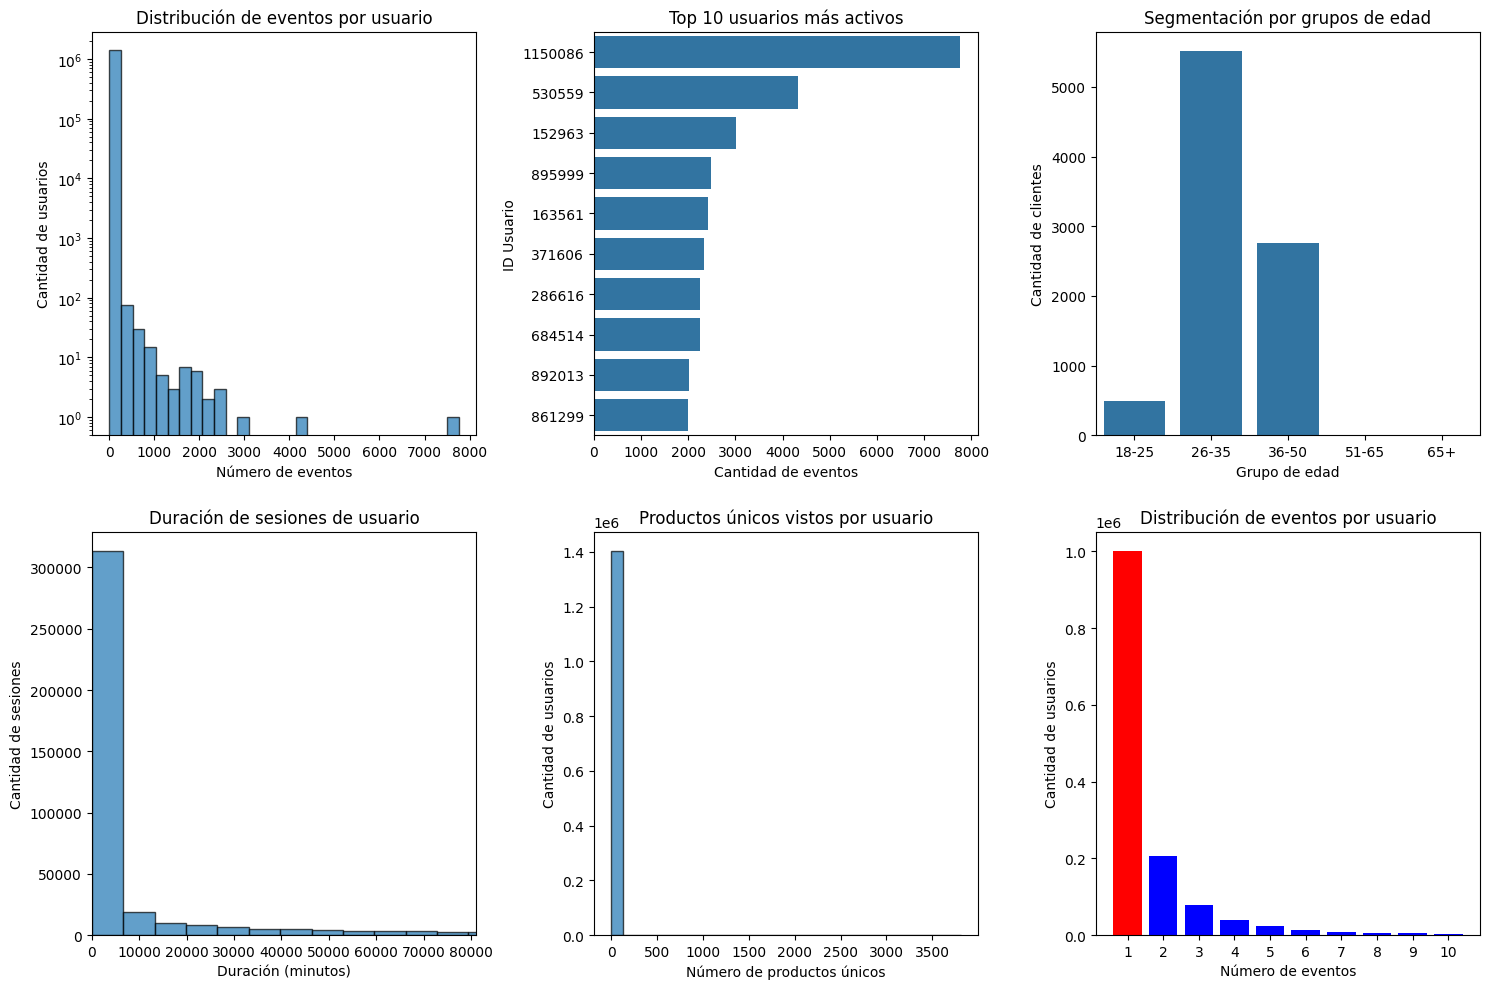

Estadísticas de comportamiento:
Usuarios únicos: 1,407,580
Eventos promedio por usuario: 2.0
Tasa de rebote (1 solo evento): 71.2%
Duración promedio de sesión: 11860.4 minutos


In [19]:
# Análisis de comportamiento de usuarios
plt.figure(figsize=(15, 10))

# Distribución de eventos por usuario
plt.subplot(2, 3, 1)
eventos_por_usuario = events['visitorid'].value_counts()
plt.hist(eventos_por_usuario, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribución de eventos por usuario")
plt.xlabel("Número de eventos")
plt.ylabel("Cantidad de usuarios")
plt.yscale('log')

# Top usuarios más activos
plt.subplot(2, 3, 2)
top_usuarios = eventos_por_usuario.head(10)
sns.barplot(x=top_usuarios.values, y=top_usuarios.index.astype(str))
plt.title("Top 10 usuarios más activos")
plt.xlabel("Cantidad de eventos")
plt.ylabel("ID Usuario")

# Segmentación de clientes por edad
plt.subplot(2, 3, 3)
cliente['grupo_edad'] = pd.cut(cliente['edad'], 
                               bins=[0, 25, 35, 50, 65, 100], 
                               labels=['18-25', '26-35', '36-50', '51-65', '65+'])
sns.countplot(x='grupo_edad', data=cliente)
plt.title("Segmentación por grupos de edad")
plt.xlabel("Grupo de edad")
plt.ylabel("Cantidad de clientes")

# Análisis de sesiones (eventos consecutivos del mismo usuario)
plt.subplot(2, 3, 4)
user_sessions = events.groupby('visitorid')['event_time'].agg(['min', 'max', 'count'])
user_sessions['duracion_min'] = (user_sessions['max'] - user_sessions['min']).dt.total_seconds() / 60
duraciones_validas = user_sessions[user_sessions['duracion_min'] > 0]['duracion_min']
plt.hist(duraciones_validas, bins=30, edgecolor='black', alpha=0.7)
plt.title("Duración de sesiones de usuario")
plt.xlabel("Duración (minutos)")
plt.ylabel("Cantidad de sesiones")
plt.xlim(0, duraciones_validas.quantile(0.95))  # Limitar a 95% para mejor visualización

# Productos únicos vistos por usuario
plt.subplot(2, 3, 5)
productos_por_usuario = events[events['event'] == 'view'].groupby('visitorid')['itemid'].nunique()
plt.hist(productos_por_usuario, bins=30, edgecolor='black', alpha=0.7)
plt.title("Productos únicos vistos por usuario")
plt.xlabel("Número de productos únicos")
plt.ylabel("Cantidad de usuarios")

# Tasa de rebote (usuarios con solo 1 evento)
plt.subplot(2, 3, 6)
rebote_data = eventos_por_usuario.value_counts().head(10)
colors = ['red' if x == 1 else 'blue' for x in rebote_data.index]
plt.bar(rebote_data.index.astype(str), rebote_data.values, color=colors)
plt.title("Distribución de eventos por usuario")
plt.xlabel("Número de eventos")
plt.ylabel("Cantidad de usuarios")

plt.tight_layout()
plt.show()

# Estadísticas clave
print("Estadísticas de comportamiento:")
print(f"Usuarios únicos: {events['visitorid'].nunique():,}")
print(f"Eventos promedio por usuario: {eventos_por_usuario.mean():.1f}")
print(f"Tasa de rebote (1 solo evento): {(eventos_por_usuario == 1).mean():.1%}")
print(f"Duración promedio de sesión: {duraciones_validas.mean():.1f} minutos")

In [20]:
valor_categoria = ventas.groupby('categoria_id')['precio'].mean().sort_values(ascending=False).head(10)

# Métricas clave de negocio
print("="*50)
print("MÉTRICAS CLAVE DE NEGOCIO")
print("="*50)
print(f"Revenue total: ${ventas['precio'].sum():,.2f}")
print(f"Transacciones totales: {ventas.shape[0]:,}")
print(f"Ticket promedio: ${ventas['precio'].mean():.2f}")
print(f"Productos más vendidos: {ventas['itemid'].mode().iloc[0] if not ventas.empty else 'N/A'}")
print(f"Categoría más rentable: {valor_categoria.index[0] if not valor_categoria.empty else 'N/A'}")
print(f"Usuarios compradores: {ventas['visitorid'].nunique():,}")
print(f"Tasa de conversión global: {(ventas['visitorid'].nunique() / events['visitorid'].nunique() * 100):.2f}%")

MÉTRICAS CLAVE DE NEGOCIO
Revenue total: $801,797.38
Transacciones totales: 22,459
Ticket promedio: $35.74
Productos más vendidos: 461686
Categoría más rentable: 38.0
Usuarios compradores: 11,719
Tasa de conversión global: 0.83%
